Image Caption Generation 

## Task 2.1: Encoder Decoder Model

Build an image caption generator model, as described in Vinyals, Oriol, et al. "Show and tell: A neural image caption generator." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015. The model shall consist of:

- Image encoder (image feature extractor)
- Caption generator (RNN-based)



## Model

### Image Encoder

In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pickle
import keras as keras
%matplotlib inline
import string
import os
from PIL import Image
import glob
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, TimeDistributed, Dense, RepeatVector, Add, Lambda,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# cd /My Drive/Colab Notebooks/preprocessed_data
!ls "/content/drive/My Drive/Colab Notebooks/preprocessed_data/data"



descriptions.pkl      encoding_test.pkl      train_cap_in
dev_cap_in	      encoding_train.pkl     train_cap_in.npy
dev_cap_in.npy	      ixtoword.pkl	     train_cap_out
dev_cap_out	      test_cap_in	     train_cap_out.npy
dev_cap_out.npy       test_cap_in.npy	     train_descriptions.pkl
dev_descriptions.pkl  test_cap_out	     train_img_in
dev_img_in	      test_cap_out.npy	     train_img_in.npy
dev_img_in.npy	      test_descriptions.pkl  wordtoix.pkl
embedding_matrix.npy  test_img_in
encoding_dev.pkl      test_img_in.npy


In [0]:
#load the preprocessed data

DATA_PATH= "/content/drive/My Drive/Colab Notebooks/preprocessed_data/data" 

desc_file = open(DATA_PATH+'/descriptions.pkl','rb')
desc = pickle.load(desc_file)

dev_desc_file = open(DATA_PATH+'/dev_descriptions.pkl','rb')
dev_desc = pickle.load(dev_desc_file)

train_desc_file = open(DATA_PATH+'/train_descriptions.pkl','rb')
train_desc = pickle.load(train_desc_file)

test_desc_file = open(DATA_PATH+'/test_descriptions.pkl','rb')
test_desc = pickle.load(test_desc_file)

encoding_dev_file = open(DATA_PATH+'/encoding_dev.pkl','rb')
encoding_dev = pickle.load(encoding_dev_file)

encoding_test_file = open(DATA_PATH+'/encoding_test.pkl','rb')
encoding_test = pickle.load(encoding_test_file)

encoding_train_file = open(DATA_PATH+'/encoding_train.pkl','rb')
encoding_train = pickle.load(encoding_train_file)

ixtoword_file = open(DATA_PATH+'/ixtoword.pkl','rb')
ixtoword = pickle.load(ixtoword_file)

wordtoix_file = open(DATA_PATH+'/wordtoix.pkl','rb')
wordtoix = pickle.load(wordtoix_file)

embedding_matrix = np.load(DATA_PATH+ '/embedding_matrix.npy')



#importing for local

# print(PREP_DATAPATH + '/data/descriptions.pkl')

# desc = pd.read_pickle('content/drive/My Drive/Colab Notebooks/preprocessed_data/data/descriptions.pkl')
# dev_desc = pd.read_pickle('data/dev_descriptions.pkl')
# train_desc = pd.read_pickle('data/train_descriptions.pkl')
# test_desc = pd.read_pickle('data/test_descriptions.pkl')
# encoding_dev = pd.read_pickle('data/encoding_dev.pkl')
# encoding_test = pd.read_pickle('data/encoding_test.pkl')
# encoding_train = pd.read_pickle('data/encoding_train.pkl')
# ixtoword = pd.read_pickle('data/ixtoword.pkl')
# wordtoix = pd.read_pickle('data/wordtoix.pkl')

# embedding_matrix = np.load('data/embedding_matrix.npy')


In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
rnn_dim = 300

In [16]:
embedding_matrix.shape

(1652, 300)

In [0]:
# image input
image_in = Input(shape=(2048,), name='image_inputs')

In [18]:
# image encoder

fe1 = Dropout(0.5, name='dropout_img_feats')(image_in)
image_dense = Dense(rnn_dim, activation='relu', name = 'dense_img_feats')
fe2 = image_dense(fe1) # reduce the dimension with FC projection

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Caption Generator

In [0]:
# caption input
cap_in = Input(shape=(None,),name='caption_inputs')

# caption embedding representation (word-based embedding)
embed_cap = Embedding(vocab_size, rnn_dim, weights = [embedding_matrix], trainable = False) # with dimension (, None, embedding_dim)
se1 = embed_cap(cap_in)

drop_cap = Dropout(0.5)
se2 = drop_cap(se1)
lstm_layer = LSTM(300)
se3 = lstm_layer(se2)


decoder1 = add([fe2, se3]) #both have dim 300
decoder2 = Dense(300, activation='relu')
dense_decoder = decoder2(decoder1)



pred_layer = Dense(vocab_size, activation='softmax') #output size is vocab size bcoz we want probability over all words in vocab
outputs = pred_layer(dense_decoder)

model = Model(inputs=[image_in, cap_in], outputs=outputs)

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
image_inputs (InputLayer)       (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    495600      caption_inputs[0][0]             
__________________________________________________________________________________________________
dropout_img_feats (Dropout)     (None, 2048)         0           image_inputs[0][0]               
__________________________________________________________________________________________________
dropout_1 

### Training

In [0]:
adam = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [23]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_desc)
print('Description Length: %d' % max_length)

Description Length: 34


In [0]:
number_pics_per_batch = 3
steps = len(train_desc)//number_pics_per_batch

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystop_callbacks = [EarlyStopping(monitor='loss', patience=10)]

In [26]:
generator = data_generator(train_desc, encoding_train, wordtoix, max_length, number_pics_per_batch)
model.fit_generator(generator, epochs=50, steps_per_epoch=steps, verbose=1, callbacks=earlystop_callbacks)
# model.save('./model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
2000/2000 [==============================] - 89s 45ms/step - loss: 3.9997 - acc: 0.2529
Epoch 2/50
2000/2000 [==============================] - 88s 44ms/step - loss: 3.3203 - acc: 0.3054
Epoch 3/50
2000/2000 [==============================] - 88s 44ms/step - loss: 3.1105 - acc: 0.3238
Epoch 4/50
2000/2000 [==============================] - 88s 44ms/step - loss: 2.9759 - acc: 0.3367
Epoch 5/50
2000/2000 [==============================] - 89s 44ms/step - loss: 2.8773 - acc: 0.3458
Epoch 6/50
2000/2000 [==============================] - 89s 45ms/step - loss: 2.7984 - acc: 0.3526
Epoch 7/50
2000/2000 [==============================] - 88s 44ms/step - loss: 2.7356 - acc: 0.3586
Epoch 8/50
2000/2000 [==============================] - 88s 44ms/step - loss: 2.6813 - acc: 0.3639
Epoch 9/50
2000/2000 [==============================] - 88s 44ms/step - loss: 2.6365 - acc: 0.3684
Epoch 10/50
2000/2000 [==============================] - 88s 

NameError: ignored

## Task 2.2: Decoder Model

Based on the completed encoder-decoder, build a decoder model for generating captions using two approaches:
- Greedy search
- Beam search

### Greedy search

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [0]:
images= "/content/drive/My Drive/Colab Notebooks/Flickr8k_Dataset/Flicker8k_Dataset/"
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

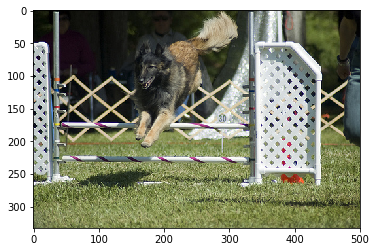

Greedy: dog is jumping over fence


In [0]:
pic = list(encoding_test.keys())[14]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(os.getcwd() + '\\data\\Flicker8k_Dataset\\'+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

### Beam search

In [0]:
"Beam Search, inspired by the example provided but tailor-made for our model"

import tensorflow as tf
import numpy as np
# import data


class Hypothesis(object):
    """Class to represent a hypothesis during beam search. Holds all the information needed for the hypothesis."""

    def __init__(self, tokens, log_probs):
        self.tokens = tokens
        self.log_probs = log_probs

    def extend(self, token, log_prob):
        """Return a NEW hypothesis, extended with the information from the latest step of beam search.

        Args:
        token: Integer. Latest token produced by beam search.
        log_prob: Float. Log prob of the latest token.
        state: Current decoder state, a LSTMStateTuple.
        Returns:
        New Hypothesis for next step.
        """
        return Hypothesis(tokens = self.tokens + [token],
        log_probs = self.log_probs + [log_prob])

    @property
    def get_tokens(self):
        return self.tokens

    @property
    def latest_token(self):
        return self.tokens[-1]

    @property
    def log_prob(self):
    # the log probability of the hypothesis so far is the sum of the log probabilities of the tokens so far
        return sum(self.log_probs)

    @property
    def avg_log_prob(self):
    # normalize log probability by number of tokens (otherwise longer sequences always have lower probability)
        return self.log_prob / len(self.tokens)


def decode_one_step(cap_inputs, img_feats, decoder_model, len_hyps, beam_size, words_indices, indices_words):

    topk_probs = []
    topk_ids = []

    for i in range(len_hyps):

        cap_input = cap_inputs[i]
        img_feat = img_feats[i]
#         print(cap_input)
        
        pred_prob_t = decoder_model.predict([img_feat, cap_input] , verbose = 0)

        topk_prob = np.sort(pred_prob_t[0], axis=-1)[-(beam_size):][::-1]

        topk_logprob = -np.log(topk_prob)

        topk_id = np.argsort(pred_prob_t[0], axis=-1)[-(beam_size):][::-1]

        topk_probs.append(topk_logprob)
        topk_ids.append(topk_id)

    return topk_probs, topk_ids

def run_beam_search(encoding, decoder_model, words_indices, indices_words, \
      min_dec_steps, max_dec_steps, num_hyps, beam_size):

    #beam search decoding 
    encoder_output = encoding
    # Initialize beam_size-many hypotheses
    hyps = [Hypothesis(tokens=[words_indices.get('startseq')],
    log_probs=[0.0]                      
                     # zero vector of length attention_length
                     ) for _ in range(num_hyps)]

    results = [] # this will contain finished hypotheses (those that have emitted the [STOP] token)

    steps = 0
    while steps < max_dec_steps and len(results) < beam_size:

        hyp_tokens = [h.get_tokens for h in hyps] # latest token produced by each hypothesis

        len_hyps = len(hyp_tokens)

        img_feats = np.array([encoder_output] * len_hyps)

        dec_inputs = []
#         dec_inputs = hyp_tokens
        for dec_input in hyp_tokens:
            dec_inputs.append(pad_sequences([dec_input], maxlen=max_length))
    # dec_inputs = np.array(dec_inputs)
    # dec_inputs = np.reshape(dec_inputs, (dec_inputs.shape[0], 1))


    # Run one step of the decoder to get the new info
        topk_log_probs, topk_ids = decode_one_step(
          dec_inputs, img_feats, decoder_model, len_hyps, beam_size, words_indices, indices_words)

        topk_log_probs = np.array(topk_log_probs)
        topk_ids = np.array(topk_ids)


    # Extend each hypothesis and collect them all in all_hyps
        all_hyps = []
        num_orig_hyps = 1 if steps == 0 else len(hyps) # On the first step, we only had one original hypothesis (the initial hypothesis). 
                                                       # On subsequent steps, all original hypotheses are distinct.
        for i in range(num_orig_hyps):
            h = hyps[i]  # take the ith hypothesis and new decoder state info
            for j in range(beam_size):  # for each of the top 2*beam_size hyps:
            # Extend the ith hypothesis with the jth option

                logprobs= np.array(topk_log_probs[i,j])
                new_hyp = h.extend(token=topk_ids[i,j], log_prob=logprobs)
                all_hyps.append(new_hyp)

        # Filter and collect any hypotheses that have produced the end token.
        hyps = [] # will contain hypotheses for the next step

        for h in sort_hyps(all_hyps): # in order of most likely h
            if h.latest_token == words_indices.get('endseq'): # if stop token is reached...
        # If this hypothesis is sufficiently long, put in results. Otherwise discard.
                if steps >= min_dec_steps:
                    results.append(h)
            else: # hasn't reached stop token, so continue to extend this hypothesis
                hyps.append(h)
            if len(hyps) == beam_size or len(results) == beam_size:
        # Once we've collected beam_size-many hypotheses for the next step, or beam_size-many complete hypotheses, stop.
                break

        steps += 1

    # At this point, either we've got beam_size results, or we've reached maximum decoder steps

    if len(results)==0: # if we don't have any complete results, add all current hypotheses (incomplete summaries) to results
        results = hyps

    # Sort hypotheses by average log probability
    hyps_sorted = sort_hyps(results)
    
    # Return the hypothesis with highest average log prob
    translated_hyps = get_string_from_hypothesis(hyps_sorted)
    return translated_hyps

def sort_hyps(hyps):
    """Return a list of Hypothesis objects, sorted by average log probability"""
    return sorted(hyps, key=lambda h: h.avg_log_prob, reverse=False)

def get_string_from_hypothesis(sorted_hyps):
    stringHyps = []
    for hypothesis in sorted_hyps:
        
        stringHyp = ''
        for token in hypothesis.tokens:
            stringHyp += ' ' + ixtoword[token]
            
        stringHyps.append(stringHyp)    
        
    return stringHyps


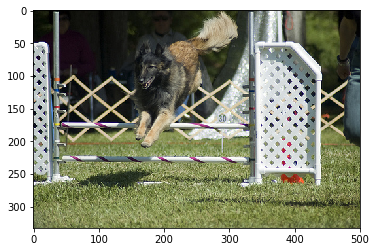

[' startseq the german shepherd dog is running through the grass endseq',
 ' startseq the german shepherd dog is trying to catch frisbee endseq',
 ' startseq the german shepherd dog is running through the field endseq',
 ' startseq the german shepherd dog is trying to catch the frisbee endseq',
 ' startseq dog runs through the grass endseq']

In [0]:
pic = list(encoding_test.keys())[14]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(os.getcwd() + '\\data\\Flicker8k_Dataset\\'+pic)
plt.imshow(x)
plt.show()
run_beam_search(image, model, wordtoix, ixtoword, 3, 32, 1, 5)
